In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys; sys.path.append('../../../tidy3d')
import tidy3d as td
from copy import copy
import tmm

from tidy3d.plugins.adjoint.components.simulation import JaxSimulation
from tidy3d.plugins.adjoint.components.geometry import JaxBox
from tidy3d.plugins.adjoint.components.medium import JaxMedium
from tidy3d.plugins.adjoint.components.structure import JaxStructure
from tidy3d.plugins.adjoint.components.data.sim_data import JaxSimulationData
from tidy3d.plugins.adjoint.web import run

[15:03:56] INFO     Using client version: 1.8.0                                                     ]8;id=626965;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/source/notebooks/../../../tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=203077;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/source/notebooks/../../../tidy3d/tidy3d/__init__.py#112\112]8;;\

In [2]:
freq0 = 2e14
subpixel = True
offset_z =1e-5
dl = 0.0125
eps0 = [2**2, 1.8**2, 1.5**2, 1.9**2]
ds0 = [0.5, 0.25, 0.5, 0.25]
bck_eps = 1.4**2
num_modes = 2

In [3]:
def compute_T_tmm(slab_eps=eps0, slab_ds=ds0):
    eps_list = [bck_eps] + slab_eps + [bck_eps]
    n_list = np.sqrt(eps_list)
    d_list = [np.inf] + slab_ds + [np.inf]
    wavelength = td.C_0 / freq0
    T = tmm.coh_tmm("p", n_list, d_list, 0, wavelength)["T"]
    return T

In [4]:
compute_T_tmm(eps0, ds0)

0.8752655778361093

In [5]:
def grad_tmm(slab_eps, slab_ds, delta=1e-4):
    """Use numerical derivative to compute the gradient of transmission through slabs with respect
    to each slab permittivity and upper and lower boundary. Uses tmm to get the analytical
    transmission results.
    """

    num_slabs = len(slab_eps)
    assert num_slabs == len(slab_ds)
    
    grad_eps = np.zeros((num_slabs,))  # gradient of each slab's permittivity
    grad_ds = np.zeros((num_slabs,))  # gradient of shifting each slab's bottom boundary

    T0 = compute_T_tmm(slab_eps, slab_ds)
    
    for islab in range(num_slabs):

        # epsilon
        eps_p = copy(slab_eps)
        eps_p[islab] += delta
        T_p = compute_T_tmm(eps_p, slab_ds)
        eps_m = copy(slab_eps)
        eps_m[islab] -= delta
        T_m = compute_T_tmm(eps_m, slab_ds)
        grad_eps[islab] = (T_p - T_m) / (2 * delta)
    
        # thicknesses
        ds_p = copy(slab_ds)
        ds_p[islab] += delta
        T_p = compute_T_tmm(slab_eps, ds_p)
        ds_m = copy(slab_ds)
        ds_m[islab] -= delta
        T_p = compute_T_tmm(slab_eps, ds_m)
        grad_ds[islab] = (T_p - T_m) / (2 * delta)
    return grad_eps, grad_ds


In [6]:
ge, gd = grad_tmm(eps0, ds0)
print(ge)
print(gd)

[-0.05588192  0.08454998  0.0097844  -0.05841657]
[-0.04149632 -0.18446432 -0.03840651 -0.32220109]


In [7]:
def make_sim(slab_eps=eps0, slab_ds=ds0, incl_fields=False):
    
    # frequency setup
    wavelength = td.C_0 / freq0
    fwidth = freq0 / 10.0
    freqs = [freq0]

    # geometry setup
    bck_medium = td.Medium(permittivity=bck_eps)

    space_above = 2
    space_below = 2

    length_x = 1.0
    center_x = 0.0
    length_z = space_below + np.sum(slab_ds) + space_above
    sim_size = (length_x, length_x, length_z)

    # make structures
    slabs = []
    z_start = -np.sum(slab_ds) / 2
    for (d, eps) in zip(slab_ds, slab_eps):
        slab = JaxStructure(
            geometry=JaxBox(center=[0, 0, z_start + offset_z + d / 2], size=[td.inf, td.inf, d]),
            medium=JaxMedium(permittivity=eps),
        )
        slabs.append(slab)
        z_start += d

    # source setup
    gaussian = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
    src_z = -length_z / 2 + 3 * space_below / 4

    source = td.PlaneWave(
        center=(center_x, 0, src_z),
        size=(td.inf, td.inf, 0),
        source_time=gaussian,
        direction="+",
        angle_theta=0,
        angle_phi=0,
        pol_angle=0,
    )

    # boundaries
    boundary_x = td.Boundary.bloch_from_source(
        source=source, domain_size=sim_size[0], axis=0, medium=bck_medium
    )
    boundary_spec = td.BoundarySpec(x=boundary_x, y=td.Boundary.periodic(), z=td.Boundary.pml(num_layers=40))
    boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML())

    # monitors
    mnt_z = length_z / 2 - wavelength
    monitor_1 = td.DiffractionMonitor(
        center=[0.0, 0.0, mnt_z],
        size=[td.inf, td.inf, 0],
        freqs=freqs,
        name="modes",
    )

    monitor_2 = td.FieldMonitor(
        center=[0.0, 0.0, mnt_z],
        size=[td.inf, td.inf, 0],
        freqs=freqs,
        name="field",
    )
    
    monitors = [monitor_2] if incl_fields else []

    # make simulation
    return JaxSimulation(
        size=sim_size,
        grid_spec=td.GridSpec.uniform(dl=dl),
        input_structures=slabs,
        sources=[source],
        monitors=monitors,
        output_monitors=[monitor_1],
        run_time=50 / fwidth,
        boundary_spec=boundary_spec,
        medium=bck_medium,
        subpixel=subpixel,
        shutoff=1e-8,
    )

def compute_T_fdtd(slab_eps=eps0, slab_ds=ds0):
    
    sim=make_sim(slab_eps=slab_eps, slab_ds=slab_ds)

    # run forward simulation
    sim_data = run(sim, task_name='slabs')
    
    # output amplitudes
    amp = sim_data["modes"].amps.sel(direction="+", f=freq0, mode_index=0)
    return abs(amp)**2

[15:03:58] ERROR    The 'DiffractionMonitor' modes requires periodic or Bloch boundaries along dimensions ]8;id=490102;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/source/notebooks/../../../tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=840561;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/source/notebooks/../../../tidy3d/tidy3d/log.py#33\33]8;;\
                    x and y.                                                                                       

SetupError: (SetupError(...), "The 'DiffractionMonitor' modes requires periodic or Bloch boundaries along dimensions x and y.")

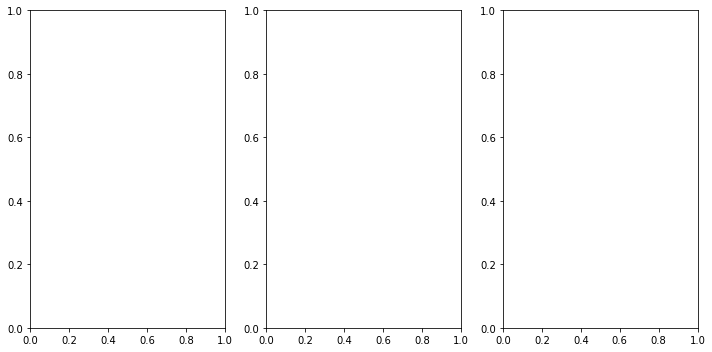

In [8]:
sim_base = make_sim(eps0, ds0)

f, axes = plt.subplots(1, 3, tight_layout=True, figsize=(10, 5))

sim_plot = sim_base.to_simulation()[0]

for dim, ax in zip('xyz', axes):
    sim_plot.plot_eps(**{dim:0}, ax=ax)
    # sim_plot.plot_grid(**{dim:0}, ax=ax)

plt.show()

print(f"total cells in simulation = {sim_base.num_cells:.1e}")

In [ ]:
sim_plot.monitors[0].mode_spec

In [ ]:
from tidy3d.plugins import ModeSolver
plane = td.Box(
    center=sim_plot.monitors[0].center,
    size=[1.0, 1.0, 0],
)
mode_solver = ModeSolver(simulation=sim_plot, plane=plane, mode_spec=sim_plot.monitors[0].mode_spec, freqs=[freq0])
modes = mode_solver.solve()

print("Effective index of computed modes: ", np.array(modes.n_eff))

fig, axs = plt.subplots(num_modes, 3, figsize=(12, 10))
for mode_ind in range(num_modes):
    mode_solver.plot_field("Ex", "real", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 0])
    mode_solver.plot_field("Ey", "real", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 1])
    mode_solver.plot_field("Ez", "real", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 2])